# Computational Graph - Perceptron
Phabel Antonio López Delgado

## 1) Computational Graph Implementation

In [ ]:
# ==============================================================================
# Import required libraries
# ==============================================================================

# Use mainly numpy for automatic differentiation: reverse mode
import numpy as np

# Libraries for plotting
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import tanh

In [ ]:
# ==============================================================================
# Define Computational Graph Node and Layer Classes
# ==============================================================================

class Node:
    """
    Base class for computational graph nodes.
    Handles storing values, gradients, and backpropagation.
    """
    # Node Constructor
    def __init__(self, value=None):
        # Forward pass value
        self.value = value
        # Compute Gradient
        self.grad = None

    # Docstring
    def __str__(self):
        # Show current node value
        return str(self.value)

    # Backpropagation Function
    def backward(self, grad=1):
        """
        Accumulate gradients during backpropagation.
        """
        # Random initialization for first time pass
        if self.grad is None:
            self.grad = np.zeros_like(self.value)
        # Update Gradient
        self.grad += grad


# Create Linear class from Node base class
class Linear(Node):
    """
    Represents a linear transformation layer: y = W*x + b
    x: input vector
    W: weight matrix
    b: bias vector
    """
    # Node Constructor
    def __init__(self, input_size, output_size):
        # Apply super Constructor
        super().__init__()
        # Set dimensions
        self.input_size = input_size
        self.output_size = output_size
        # Initialize weights and biases to small random values
        self.w = None  # Weights matrix
        self.b = None  # Bias vector
        # Store input node for backpropagation
        self.input_node = None

    # Forward Function
    def __call__(self, input_node_x):
        """
        Forward pass: compute linear transformation with current weights and biases.
        """
        # Random initialization of weights and biases
        # Check for first forward pass
        if self.w is None:
            self.w = np.random.randn(self.output_size, self.input_size) * 0.01
        if self.b is None:
            self.b = np.zeros(self.output_size)
        # Set parent Node
        self.input_node = input_node_x
        # Set forward value: y = W*x + b
        self.value = self.w @ input_node_x.value + self.b
        # Return Node
        return self

    # Backward Function for automatic differentiation
    def backward(self, grad=1):
        """
        Backward pass: compute gradients w.r.t. weights, biases, and input.
        """
        # Gradient w.r.t. weights. Shape: (output_size, input_size)
        self.w_grad = np.outer(grad, self.input_node.value)
        # Gradient w.r.t. biases
        self.b_grad = grad.copy()
        # Compute Gradient
        grad_input = self.w.T @ grad
        # Backpropagate gradient to input node. Shape: (input_size,)
        self.input_node.backward(grad=grad_input)


# Create Tanh Activation class from Node base class
class Tanh(Node):
    """
    Non-Linear activation function: hyperbolic tangent.
    Input: Linear transformation output.
    """
    # Node Constructor
    def __init__(self):
        # Apply super Constructor
        super().__init__()
        # Store input node for backpropagation
        self.input_node = None

    # Forward Function
    def __call__(self, input_node_x):
        """
        Forward pass: apply tanh activation to linear transformation output.
        """
        # Set parent Node
        self.input_node = input_node_x
        # Set forward value: A = tanh(y), y = W*x + b
        self.value = np.tanh(input_node_x.value)
        # Return Node
        return self

    # Backward Function with automatic differentiation
    def backward(self, grad=1):
        """
        Derivative of tanh w.r.t y = 1 - tanh^2(y)
        """
        # Compute Gradient
        local_grad = (1 - np.tanh(self.value) ** 2)
        # Backpropagate gradient to input node.
        self.input_node.backward(grad=local_grad * grad)


# Create Softmax class from Node base class
class Softmax(Node):
    """
    Softmax activation for multi-class classification.
    """
    # Node Constructor
    def __init__(self):
        # Apply super Constructor
        super().__init__()
        # Store input node for backpropagation
        self.input_node = None

    # Forward Function
    def __call__(self, input_node_x):
        """
        Forward pass: compute softmax probabilities.
        """
        # Set forward value: S = Softmax(A)
        e_x = np.exp(input_node_x.value - np.max(input_node_x.value))
        self.value = e_x / e_x.sum()
        # Set parent Node
        self.input_node = input_node_x
        # Return Node
        return self

    # Backward Function with automatic differentiation
    def backward(self, grad=1):
        """
        Backpropagation for softmax + cross-entropy simplifies, but here implemented generally.
        """
        # Compute Gradient
        local_grad = self.value * (1 - self.value)
        # Backpropagate gradient to input node.
        self.input_node.backward(grad=local_grad * grad)


# Create Loss Function class from Node base class
class CrossEntropy(Node):
    """
    Cross-entropy loss function for multi-class classification.
    """
    # Node Constructor
    def __init__(self):
        # Apply super Constructor
        super().__init__()
        # Set Probabilities
        self.probs = None
        # Set Target Class index
        self.target = None
        # Store input node for backpropagation
        self.input_node = None

    # Forward Function
    def __call__(self, input_node_x, target_index):
        """
        Compute cross-entropy loss function given softmax probabilities and target class index.
        """
        # Set parent Node
        self.input_node = input_node_x
        # Get Probabilities from parent Node
        self.probs = input_node_x.value
        # Get Target Class index
        self.target = target_index
        # Compute loss function. Add epsilon of 1e-15 for numerical stability
        epsilon = 1e-15
        self.value = -np.log(self.probs[self.target] + epsilon)
        # Return Node
        return self

    # Backward Function with automatic differentiation
    def backward(self, grad=1):
        """
        Gradient of cross-entropy loss function w.r.t. probabilities.
        """
        # Compute Gradient
        grad_probs = self.probs.copy()
        grad_probs[self.target] -= 1
        # Backpropagate gradient to input node
        self.input_node.backward(grad=grad_probs * grad)


## 2) Train with Softmax(Tanh(Linear))

100%|██████████| 200/200 [00:02<00:00, 97.95it/s] 


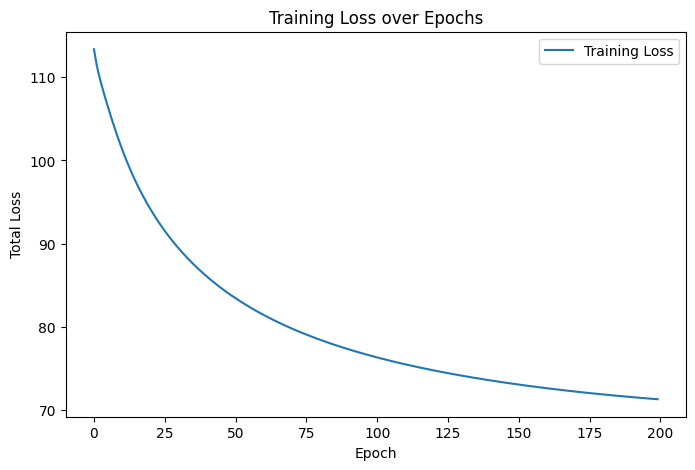

Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.38      0.56        13
           2       0.62      1.00      0.76        13

    accuracy                           0.82        45
   macro avg       0.87      0.79      0.77        45
weighted avg       0.89      0.82      0.80        45



In [ ]:
# ==============================================================================
# Model Data
# ==============================================================================

# Load and Prepare Data: Use Iris Dataset for simplicity
data = load_iris()
# Features
x = data.data
# Labels
y = data.target
# Number of features
dim = len(data.feature_names)
# Number of classes
classes = len(data.target_names)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


# ==============================================================================
# Model: Single linear layer (no hidden layer)
# ==============================================================================
linear = Linear(dim, classes)
tanh = Tanh()
softmax = Softmax()
loss_fn = CrossEntropy()


# ==============================================================================
# Training
# ==============================================================================

# Training Parameters
epochs = 200
learning_rate = 0.001
loss_history = list()

# Train
for epoch in tqdm(range(epochs)):
    epoch_loss = 0

    # Reset gradients before each epoch
    if hasattr(linear, 'w_grad'):
        linear.w_grad = np.zeros_like(linear.w)
    if hasattr(linear, 'b_grad'):
        linear.b_grad = np.zeros_like(linear.b)

    # Iterate
    for x_i, y_i in zip(x_train, y_train):
        # Create input node for current sample
        input_node = Node(value=x_i)

        # Forward pass: linear transformation + activation + softmax
        logits_node = linear(input_node)
        activation_node = tanh(logits_node)
        probs_node = softmax(activation_node)

        # Calculate loss
        loss = loss_fn(probs_node, y_i)

        # Backward pass: compute gradients
        loss.backward()

        # Update weights and biases using gradient descent
        linear.w -= learning_rate * linear.w_grad
        linear.b -= learning_rate * linear.b_grad

        # Accumulate loss for monitoring
        epoch_loss += loss.value

    # Store total loss for the epoch
    loss_history.append(epoch_loss)

# ==========================
# Plot Training Loss
# ==========================
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# ==========================
# Model Evaluation
# ==========================
predictions = []

for x_i in x_test:
    # Forward pass for each test sample
    x_node = Node()
    x_node.value = x_i

    logits_node = linear(x_node)
    probs_node = Softmax()(logits_node)

    # Predicted class is the one with highest probability
    pred_class = np.argmax(probs_node.value)
    predictions.append(pred_class)

# Print classification report
print("Classification Report on Test Data:\n")
print(classification_report(y_test, predictions))

# 3) Train with Softmax(Linear)

100%|██████████| 100/100 [00:00<00:00, 233.49it/s]


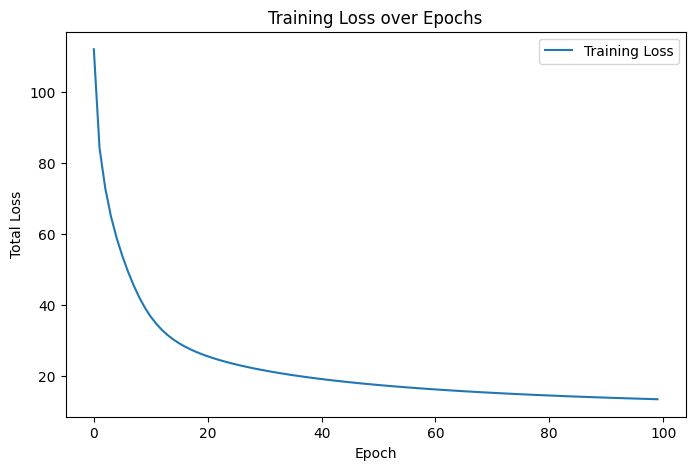

Classification Report on Test Data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      0.92      0.96        13
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45



In [ ]:
# ==============================================================================
# Model Data
# ==============================================================================

# Load and Prepare Data: Use Iris Dataset for simplicity
data = load_iris()
# Features
x = data.data
# Labels
y = data.target
# Number of features
dim = len(data.feature_names)
# Number of classes
classes = len(data.target_names)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


# ==============================================================================
# Model: Single linear layer (no hidden layer)
# ==============================================================================
linear = Linear(dim, classes)
softmax = Softmax()
loss_fn = CrossEntropy()


# ==============================================================================
# Training
# ==============================================================================

# Training Parameters
epochs = 100
learning_rate = 0.1
loss_history = list()

# Train
for epoch in tqdm(range(epochs)):
    epoch_loss = 0

    # Reset gradients before each epoch
    if hasattr(linear, 'w_grad'):
        linear.w_grad = np.zeros_like(linear.w)
    if hasattr(linear, 'b_grad'):
        linear.b_grad = np.zeros_like(linear.b)

    # Iterate
    for x_i, y_i in zip(x_train, y_train):
        # Create input node for current sample
        input_node = Node(value=x_i)

        # Forward pass: linear transformation + activation + softmax
        logits_node = linear(input_node)
        probs_node = softmax(logits_node)

        # Calculate loss
        loss = loss_fn(probs_node, y_i)

        # Backward pass: compute gradients
        loss.backward()

        # Update weights and biases using gradient descent
        linear.w -= learning_rate * linear.w_grad
        linear.b -= learning_rate * linear.b_grad

        # Accumulate loss for monitoring
        epoch_loss += loss.value

    # Store total loss for the epoch
    loss_history.append(epoch_loss)

# ==========================
# Plot Training Loss
# ==========================
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# ==========================
# Model Evaluation
# ==========================
predictions = []

for x_i in x_test:
    # Forward pass for each test sample
    x_node = Node()
    x_node.value = x_i

    logits_node = linear(x_node)
    probs_node = Softmax()(logits_node)

    # Predicted class is the one with highest probability
    pred_class = np.argmax(probs_node.value)
    predictions.append(pred_class)

# Print classification report
print("Classification Report on Test Data:\n")
print(classification_report(y_test, predictions))

## 4) Conclusion

The Computational Graph Implementation allows for efficient autograd reverse differentiation and good results. Here, the Iris Dataset was chosen for training. It is a small dataset, therefore, the softmax(linear) implementation worked better than the softmax(tanh(linear)) one, with probably overfitted or was not suitable for the task. Other non-linear activation functions can be used, e.g. ReLu. The Softmax(Linear) method had an excellent and efficient result by using Computational Graphs with autograd reverse differentiation.